### lab 2 missense prediction w/ feature intersection
* only missense clinvar
* use positions w/ mpc **OR** pathogenic fraction

In [11]:
import pandas, numpy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.externals.six import StringIO
from IPython.display import HTML
%matplotlib inline

In [2]:
def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    return pandas.Series([frac, len(rows)], index=['path_frac', 'size'])

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t').fillna(0)
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)
ff = dd.reset_index()

# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if pfam in domain_info:
            if domain_info[pfam][2] == 0:
                ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            if pfam in domain_info:
                return domain_info[pfam]
        
    if len(ls):
        return ls[0]
    else:
        return (0, 0, 1)
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff.values}

df_pre.loc[:, 'path_frac_t'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size_t'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)
df_pre.loc[:, 'in_none_pfam'] = df_pre.apply(lambda row: 1 if 'none' in df_pre['pfam'] else 0, axis=1)

In [6]:
# this is for training
# use not just missense
# I do not need to require an mpc score here anymore
df_x_pre = df_pre[ (df_pre.clin_class != 'VUS') & 
                   (df_pre.mpc>0)]
df_s = df_x_pre.groupby('pfam').size().reset_index()
multi_pfam = set( df_s[df_s[0]>1]['pfam'].values )
df_x_pre.loc[:, 'multi_pfam'] = df_x_pre.apply(lambda row: row['pfam'] in multi_pfam, axis=1)
df_x = df_x_pre[df_x_pre.multi_pfam]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()
genes = set(df_x['gene'].values)

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
clin_file = '../data/interim/panel_two.eff.dbnsfp.anno.hHack.dat.xls'
clinvar_df_pre_pre = pandas.read_csv(clin_file, sep='\t').fillna(0)
crit = clinvar_df_pre_pre.apply(lambda row: row['gene'] in genes, axis=1)
clinvar_df_pre = clinvar_df_pre_pre[crit]

def calc_final_sig(row):
    if row['clin_class'] in ('pathogenic', 'pathogenic_recessive', 'pathogenic_dominant', 'likely_pathogenic'):
        return 1
    if row['clin_class'] in ('benign', 'likely_benign'):
        return 0
    return -1

clinvar_df_pre.loc[:, "y"] = clinvar_df_pre.apply(calc_final_sig, axis=1)
clinvar_df = clinvar_df_pre[(clinvar_df_pre.eff=='missense_variant') 
                            & (clinvar_df_pre.y!=-1) 
                            & (clinvar_df_pre.mpc>0)
                            & (clinvar_df_pre.pfam != 'fuck')].drop_duplicates()
clinvar_df.loc[:, 'path_frac_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[0], axis=1)
clinvar_df.loc[:, 'size_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[1], axis=1)
clinvar_df.loc[:, 'path_na_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[2], axis=1)
clinvar_df.loc[:, 'in_none_pfam'] = clinvar_df.apply(lambda row: 1 if 'none' in row['pfam'] else 0, axis=1)
# need a smarter match to domain here
#m = pandas.merge(clinvar_df, ff, on='pfam', how='left')
#m.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
print(len(clinvar_df))
print(len(clinvar_df[clinvar_df.y==1]))
print(len(clinvar_df[clinvar_df.y==0]))

75
15
60


In [9]:
clinvar_df.head()

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,exac_cov_frac,kaviar_af,c.,Protein_Change,Hugo_Symbol,y,path_frac_t,size_t,path_na_t,in_none_pfam
129,1,154541950,C,T,likely_benign,none25733,0.000200,missense_variant,3,1461,...,0.9983,0.000746,NM_000748.2:c.77C>T,T26M,CHRNB2,0,-1.000000,2.0,1,1
138,1,154544158,G,A,pathogenic_dominant,Neur_chan_memb:3,0.000000,missense_variant,1,1463,...,0.9997,0.000006,NM_000748.2:c.859G>A,V287M,CHRNB2,1,0.142857,16.0,0,0
139,1,154544158,G,T,likely_pathogenic,Neur_chan_memb:3,0.000000,missense_variant,2,1462,...,0.9997,0.000006,NM_000748.2:c.859G>T,V287L,CHRNB2,1,0.142857,16.0,0,0
143,1,154544490,G,C,benign,Neur_chan_memb:3,0.001797,missense_variant,24,1440,...,0.0726,0.001916,NM_000748.2:c.1191G>C,Q397H,CHRNB2,0,0.142857,16.0,0,0
145,1,154544534,G,A,benign,Neur_chan_memb:3,0.000000,missense_variant,11,1453,...,0.0673,0.000231,NM_000748.2:c.1235G>A,G412D,CHRNB2,0,0.142857,16.0,0,0


In [13]:
# train new tree and apply to clinvar
tree_clf = linear_model.LinearRegression(normalize=True, fit_intercept=True)
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)

all_preds = []
all_truth = []
cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = poly.fit_transform(df_x[cols]), df_x['y']
tree_clf.fit(X, y)

X_clin, y_clin = poly.fit_transform(clinvar_df[cols]), clinvar_df['y']
preds = tree_clf.predict(X_clin)
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
tree_auc = metrics.auc(fpr_tree, tpr_tree)

In [14]:
# train new tree and apply to clinvar: just pathogenic frac
tree_clf = linear_model.LinearRegression(normalize=True, fit_intercept=True)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

all_preds = []
all_truth = []
cols = ['size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)

X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
preds = tree_clf.predict(X_clin)
fpr_tree_nm, tpr_tree_nm, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
tree_auc_nm = metrics.auc(fpr_tree_nm, tpr_tree_nm)

In [15]:
scores = clinvar_df['mpc'].values
truth = clinvar_df['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)

mpc auc 0.982222222222
tree auc 0.68
tree-no-mpc auc 0.318333333333


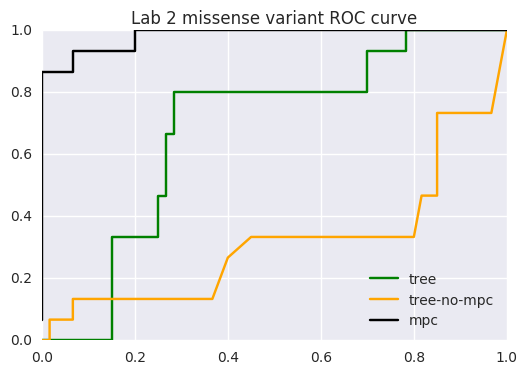

In [16]:
#X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
#preds = tree_clf.predict_proba(X_clin)
#fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, [x[1] for x in preds], pos_label=1)
#tree_auc = metrics.auc(fpr_tree, tpr_tree)
#mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)
print('mpc auc', mpc_auc)
print('tree auc', tree_auc)
print('tree-no-mpc auc', tree_auc_nm)
plt.plot(fpr_tree, tpr_tree, label='tree', color='green')
plt.plot(fpr_tree_nm, tpr_tree_nm, label='tree-no-mpc', color='orange')
plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
plt.legend(loc=4)
plt.title('Lab 2 missense variant ROC curve')
#plt.savefig('../docs/plots/missense_clinvar_roc_feature_union.png')